### Import dependencies

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

/Users/maksim/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Prepare data

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

def flatten_images(x):
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

X_train = flatten_images(X_train)
X_test = flatten_images(X_test)

def labels_to_mask(y):
    result = np.zeros((y.size, 10))
    result[np.arange(y.size), y] = 1
    return result

y_train_mask = labels_to_mask(y_train)
y_test_mask = labels_to_mask(y_test)



Using TensorFlow backend.


### A script for testing algorithms

In [3]:
def batching(n, size=512):
    for i in range(n):
        batch_index = np.random.choice(np.arange(X_train.shape[0]), size)
        yield (X_train[batch_index], y_train_mask[batch_index])

def run(algorithm, iters=250, show_graph=True):
    input_X = tf.placeholder('float64', (None, X_train.shape[1]), name="X")
    input_y = tf.placeholder('int32', (None, 10), name="y")

    optimizer, model, loss = algorithm(input_X, input_y)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        train_losses = []
        test_losses = []

        for X, y in batching(iters):
            
            if show_graph:
                train_losses.append(sess.run(loss, {input_X: X, input_y: y}))
                test_losses.append(sess.run(loss, {input_X: X_test, input_y: y_test_mask}))
            
            sess.run(optimizer, {input_X: X, input_y: y})

        y_pred = sess.run(model, {input_X: X_test})

    if show_graph:
        x = range(iters)
        plt.plot(x, train_losses, 'b')
        plt.plot(x, test_losses, 'g')
        plt.show()

    print("accuracy:", accuracy_score(y_pred, y_test))

### Two layer neural network

Just as suggested, I will make:

$$ input -> dense_1 -> sigmoid -> dense_2 -> softmax -> output$$

$dense_1$ is performed with $W_1$ ($n_{features} * n_{neurons}$) and $b_1$.

$dense_2$ - with $W_2$ ($n_{neurons} * n_{classes}$) and $b_2$.

I'll take $n_{neurons} = 128$.

In [4]:
def two_layer_nn(tensorX, tensorY, n_classes=10, n_neurons=128):
    n_features = int(tensorX.shape[1])
    w1 = tf.Variable(tf.truncated_normal(shape=(n_features, n_neurons), stddev=0.001, dtype='float64'), 
                     dtype='float64', name="W1")
    w2 = tf.Variable(tf.truncated_normal(shape=(n_neurons, n_classes), stddev=0.001, dtype='float64'), 
                     dtype='float64', name="W2")
    b1 = tf.Variable(1., dtype='float64', name="b1")
    b2 = tf.Variable(1., dtype='float64', name="b2")
    
    activation1 = tf.squeeze(tf.sigmoid(tf.matmul(tensorX, w1) + b1))
    
    softmax = tf.nn.softmax(tf.matmul(activation1, w2) + b2)
    loss = tf.losses.softmax_cross_entropy(tensorY, softmax)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss, var_list=[w1, w2, b1, b2])
    
    model = tf.argmax(softmax, axis=1)
    
    return (optimizer, model, loss)

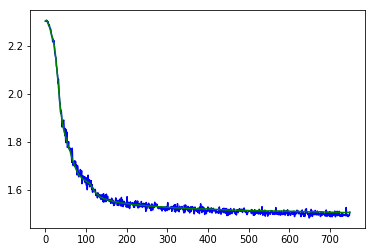

accuracy: 0.9587
CPU times: user 3min 52s, sys: 12.6 s, total: 4min 5s
Wall time: 1min 19s


In [5]:
%%time
run(two_layer_nn, iters=750)